<a href="https://colab.research.google.com/github/Rajarshi1001/model-zoo-submissions/blob/main/ResNet_34.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input
from keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator
from tensorflow.keras.layers import  Dropout,ZeroPadding2D, Conv2D,LeakyReLU, MaxPool2D, Flatten, Dense, Add, BatchNormalization, Activation,  AveragePooling2D,GlobalAveragePooling2D
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image
import pandas as pd
import torchvision
from torchvision.datasets.utils import download_url
import numpy as np
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.optimizers import Adam
import tarfile
import os

In [2]:
dataset_url='https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz'
download_url(dataset_url,'.')
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
  tar.extractall(path='./data')
# dataset is opened in the folder format in order to understand the distribution by ploting a barplot.

Using downloaded and verified file: ./cifar10.tgz


Total number of images in the dataset :  50000




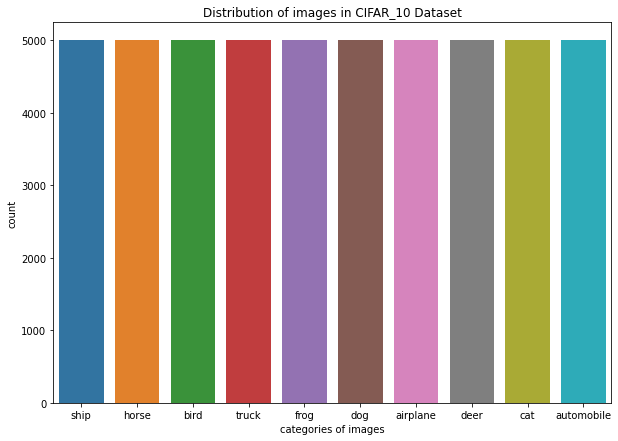

In [3]:
data_url = 'data/cifar10' #dadaset directory
img_list = []
class_list = [] #contains the 10 classes 
train_url = os.path.join(data_url,'train')
test_url = os.path.join(data_url, 'test')
train_classes = os.listdir(train_url)
count_dict = {n : 0 for n in train_classes}
for index, label in enumerate(train_classes):
  class_url = os.path.join(train_url, '{}'.format(label))
  class_list.append(class_url)
  for images in os.listdir(class_url):
    img_list.append(images)
    count_dict[label] += 1
df = pd.DataFrame(count_dict, index=[0])
fig, axs = plt.subplots(figsize=(10,7))
ax = sns.barplot(data = df)
sns.set_style('darkgrid')
ax.set(xlabel="categories of images", ylabel="count")
ax.set_title("Distribution of images in CIFAR_10 Dataset")
print('Total number of images in the dataset : ', len(img_list))
print('\n')
#img_list contains the number of images present in the training sample
#count_dict contains the key value pairs of the classes and the number of images belonging to that class in the training sample

In [4]:
(X_train, y_train),(X_test, y_test) = tf.keras.datasets.cifar10.load_data() #loads the dadaset and divides it into training samples and testing samples(numpy array)


In [5]:
mean= np.mean(X_train)
std= np.mean(X_train)
num_classes = 10
X_train = X_train.astype('float32') / .255
X_test = X_test.astype('float32') / .255
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

The failure of the 56-layer CNN could be blamed on the optimization function, initialization of the network, or the famous vanishing/exploding gradient problem. Vanishing gradients are especially easy to blame for this, however, the authors argue that the use of Batch Normalization ensures that the gradients have healthy norms. Amongst the many theories explaining why Deeper Networks fail to perform better than their Shallow counterparts, it is sometimes better to look for empirical results for explanation and work backwards from there. The problem of training very deep networks has been alleviated with the introduction of a new neural network layer — The Residual Block.
Resnet-34 is a model which uses the residual blocks to overcome the vanishing gradient problem.






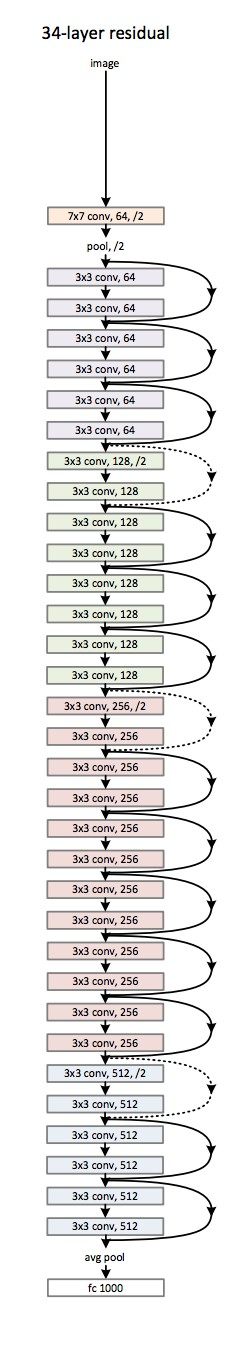

In [6]:
def identity_map(X,filter):
  Shortcut = X
  # Shortcut represent a skip connection that originates from the first layer in a identity_map
  #X represents the output tensor coming fro a convoluted layer that acts as an input tensor in the preojection_map.
  #filter represents the numbers of filters applied to each layer in the projection map for feature extraction.

  F1 = filter 
  #assigns the identical filter size to a particular stage in the network 
  X = Conv2D(filters= F1, kernel_size=(3,3), kernel_initializer="he_uniform",padding="same")(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)
  
  X = Conv2D(filters= F1, kernel_size=(3,3), kernel_initializer="he_uniform", padding="same")(X)
  X = BatchNormalization()(X)
  X = Add()([X , Shortcut])
  X = Activation('relu')(X)
  # Identity map refers to that the input shape = output shape
  return X

def projection_map(X, filter, stride=(1,1)):
  F1 = filter
  Shortcut = X
  # Shortcut represent a skip connection that originates from the first layer in a projection_map
  '''
  #X represents the output tensor coming fro a convoluted layer that acts as an input tensor in the preojection_map.
  #filter represents the numbers of filters applied to each layer in the projection map for feature extraction.
  #Stride = striding used in the convolution layer to obtain the residual from the input.
  '''
 
  X = Conv2D(filters= F1, kernel_size=(3,3),padding="same",strides=stride)(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)

  X = Conv2D(filters= F1, kernel_size=(3,3),padding="same")(X)
  X = BatchNormalization()(X)

  Shortcut = Conv2D(filters = F1 , padding="same", kernel_size=(1,1),strides=stride)(Shortcut)
  Shortcut = BatchNormalization()(Shortcut)

  X = Add()([X , Shortcut])
  X = Activation('relu')(X)
  #projection map is used when the input shape != output shape, 1x1 convoultion layer is attached to the identity_map in projection_map to expand the dimensions
  return X

In [7]:
def resnet_34(X):
 
 #X = ZeroPadding2D((3, 3))(inputs) 
 X = Conv2D(64,kernel_size=(7,7), strides=(2,2),kernel_initializer="glorot_uniform")(X)
 #X = BatchNormalization(axis=3)
 #X = Activation('relu')(X)
 X = MaxPool2D(strides=(2,2), padding="same")(X)

 X = identity_map(X,64)
 X = identity_map(X,64)
 X = identity_map(X,64)

 X = projection_map(X,128,(2,2))

 X = identity_map(X,128)
 X = identity_map(X,128)
 X = identity_map(X,128)

 X = projection_map(X,256,(2,2))

 X = identity_map(X,256)
 X = identity_map(X,256)
 X = identity_map(X,256)
 X = identity_map(X,256)
 X = identity_map(X,256)

 X = projection_map(X,512,(2,2))
 X = identity_map(X,512)
 X = identity_map(X,512)
 X = GlobalAveragePooling2D()(X)
 X = Dense(10, activation="softmax")(X)
 # output channels = 10 because there are 10 classes in the dataset.
 #model1= Model(inputs = input, outputs = outputs)
 
 return X


In [8]:
img_tensor = Input(shape=[32,32,3])
var = resnet_34(img_tensor)
model1 = Model(inputs = img_tensor, outputs = var)
model1.compile(loss ="categorical_crossentropy", optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])


In [9]:
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=0,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=False)
datagen.fit(X_train)

In [10]:
#USING DATA AUGMENTATION
hist = model1.fit(x=datagen.flow(X_train, y_train, batch_size=64),
              verbose=1,
              epochs=70,
              validation_data=(X_test, y_test),
              steps_per_epoch=len(img_list)/64
)

Epoch 1/70
781/781 [==============================] - 55s 52ms/step - loss: 30.7903 - accuracy: 0.2306 - val_loss: 1.7121 - val_accuracy: 0.3708
Epoch 2/70
781/781 [==============================] - 39s 50ms/step - loss: 1.7307 - accuracy: 0.3640 - val_loss: 1.5665 - val_accuracy: 0.4111
Epoch 3/70
781/781 [==============================] - 39s 50ms/step - loss: 1.6024 - accuracy: 0.4150 - val_loss: 1.6569 - val_accuracy: 0.4059
Epoch 4/70
781/781 [==============================] - 41s 52ms/step - loss: 1.5416 - accuracy: 0.4406 - val_loss: 1.4601 - val_accuracy: 0.4699
Epoch 5/70
781/781 [==============================] - 39s 50ms/step - loss: 1.4656 - accuracy: 0.4668 - val_loss: 1.3788 - val_accuracy: 0.4964
Epoch 6/70
781/781 [==============================] - 39s 50ms/step - loss: 1.4148 - accuracy: 0.4881 - val_loss: 1.3394 - val_accuracy: 0.5221
Epoch 7/70
781/781 [==============================] - 39s 50ms/step - loss: 1.3797 - accuracy: 0.5050 - val_loss: 1.3236 - val_accuracy

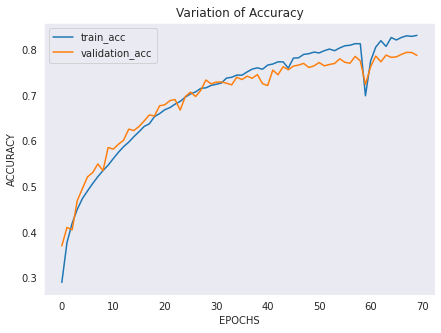

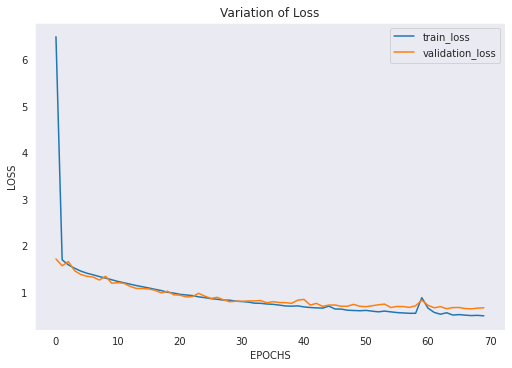

In [11]:
epoch = range(70)
train_acc = hist.history['accuracy']
train_loss = hist.history['loss']
validation_acc = hist.history['val_accuracy']
validation_loss = hist.history['val_loss']
#fig ,ax= plt.subplots(nrows=1,ncols=2)

#This plot shows the variation of training accuracy and the validation accuracy with epochs
fig = plt.figure(figsize=(7,5))
plt.plot(epoch, train_acc)
plt.plot(epoch, validation_acc)
plt.xlabel("EPOCHS")
plt.ylabel("ACCURACY")
plt.title("Variation of Accuracy")
plt.legend(['train_acc','validation_acc'])
plt.grid()


#This plot shows the variation of training loss and the validation loss with epochs
fig = plt.figure(figsize=(7,5))
plt.plot(epoch, train_loss)
plt.plot(epoch, validation_loss)
plt.xlabel("EPOCHS")
plt.ylabel("LOSS")
plt.title("Variation of Loss")
plt.legend(['train_loss', 'validation_loss'])
plt.grid()
fig.tight_layout(pad=0.3)

In [12]:
#model.save('resnet34_keras.h5')
model1.evaluate(X_test, y_test)

313/313 [==============================] - 4s 12ms/step - loss: 0.6625 - accuracy: 0.7882


[0.6625410914421082, 0.7882000207901001]

In [23]:
## WITHOUT USING DATA AUGMENTATION
print(model.summary())
val_imgs = X_train[-3000 : ]
X_train = X_train[ : -3000 ]
val_label = y_train[-3000 : ]
y_train= y_train[ : -3000 ]
img_tensor = Input(shape=[32,32,3])
var = resnet_34(img_tensor)
model = Model(inputs = img_tensor, outputs = var)
model.compile(loss = "categorical_crossentropy", optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
hist = model.fit(X_train, y_train, epochs = 70, batch_size = 64, validation_data=(val_imgs, val_label))
#hist stores the entire histore of training acc, training loss, val_acc , val_loss.

#this is the second training of the model with 50 epochs

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 21,315,082
Trainable params: 21,298,186
Non-trainable params: 16,896
__________________________________________________________________________________________________
None
Epoch 1/70
735/735 [==============================] - 32s 39ms/step - loss: 37.6084 - accuracy: 0.2567 - val_loss: 1.6961 - val_accuracy: 0.3860
Epoch 2/70
735/735 [==============================] - 27s 37ms/step - loss: 1.5926 - accuracy: 0.4145 - val_loss: 1.5063 - val_accuracy: 0.4587
Epoch 3/70
735/735 [==============================] - 27s 37ms/step - loss: 1.4555 - accuracy: 0.4765 - val_loss: 1.4193 - val_accuracy: 0.4733
Epoch 4/70
735/735 [==============================] - 27s 37ms/step - loss: 1.3694 - accuracy: 0.5093 - val_loss: 1.3770 - val_accuracy: 0.5050
Epoch 5/70
735/735 [===

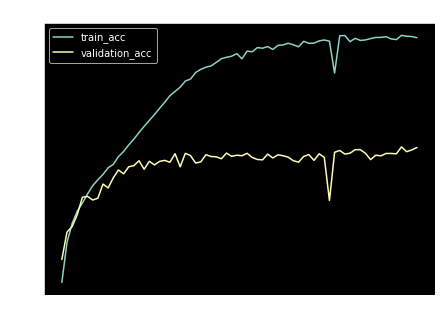

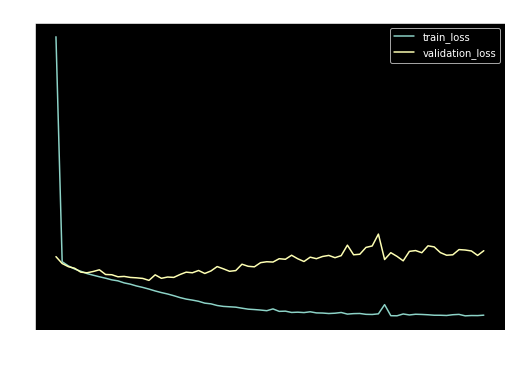

In [24]:
epoch = range(70)
train_acc = hist.history['accuracy']
train_loss = hist.history['loss']
validation_acc = hist.history['val_accuracy']
validation_loss = hist.history['val_loss']
#fig ,ax= plt.subplots(nrows=1,ncols=2)

#This plot shows the variation of training accuracy and the validation accuracy with epochs
fig = plt.figure(figsize=(7,5))
plt.plot(epoch, train_acc)
plt.plot(epoch, validation_acc)
plt.xlabel("EPOCHS")
plt.ylabel("ACCURACY")
plt.title("Variation of Accuracy")
plt.legend(['train_acc','validation_acc'])
plt.grid()


#This plot shows the variation of training loss and the validation loss with epochs
fig = plt.figure(figsize=(7,5))
plt.plot(epoch, train_loss)
plt.plot(epoch, validation_loss)
plt.xlabel("EPOCHS")
plt.ylabel("LOSS")
plt.title("Variation of Loss")
plt.legend(['train_loss', 'validation_loss'])
plt.grid()
fig.tight_layout(pad=0.3)

In [31]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 4s 12ms/step - loss: 2.0135 - accuracy: 0.6605


[2.013503074645996, 0.6604999899864197]